In [334]:
import requests
from dotenv import load_dotenv
import os
import numpy as np
import pandas as pd
load_dotenv()
API_KEY = os.getenv('API_KEY')
import time
import schedule
import matplotlib.pyplot as plt

In [396]:
def get_all_sports():
    """
    This function gets all the sports from odds api and returns it

    Returns:
        sports: a list of sports on avalible with the odds api
    """
    
    sports_url = f'https://api.the-odds-api.com/v4/sports/?apiKey={API_KEY}'

    sports_response = requests.get(sports_url)
    sports_data = sports_response.json()

    sports = []
    for sport in sports_data:
        sports.append(sport['key'])

    return sports

def get_sport_teams_odds(sport):
    """gets the different teams playing and sports book odds for each team given the parameter sport

    Args:
        sport (String): the sport we want to get the team odds for

    Returns:
        sport_team_odds: returns a list of tubles, containing the teams playing, followed by a pd df
        containing the sports books, and odds for each team for each sports book. We have n tubles for n 
        teams playing in the sport
        
    """
    

    sport_team_odds_url = f'https://api.the-odds-api.com/v4/sports/{sport}/odds/?apiKey={API_KEY}&regions=us&markets=h2h,spreads&oddsFormat=american'
    response = requests.get(sport_team_odds_url)
    data = response.json()
    
    if len(data) <= 2:
        return None
    
    sport_team_odds = []
    for team in data:
        
        sports_teams = f"{team['bookmakers'][0]['markets'][0]['outcomes'][0]['name']} vs {team['bookmakers'][0]['markets'][0]['outcomes'][1]['name']}"
        
        books = []
        odds1 = []
        odds2 = []
        for odds in team['bookmakers']:
            books.append(odds['title'])
            odds1.append(odds['markets'][0]['outcomes'][0]['price'])
            odds2.append(odds['markets'][0]['outcomes'][1]['price']) 
        
        data = {
                'Books': books,
                'Odds1': odds1,
                'Odds2': odds2
            }
        team_odds = (sports_teams, pd.DataFrame(data))
        sport_team_odds.append(team_odds)
    return sport_team_odds

def calc_arb_opp(sport_odds):
    
    for game_index in range(len(sport_odds)):
        # print(sport_odds[game_index][0])
        max_odds1 = sport_odds[game_index][1]['Odds1'].max()
        max_odds2 = sport_odds[game_index][1]['Odds2'].max()
        
        implied_prob = find_probs(max_odds1, max_odds2) 
        max_odds1_book = sport_odds[game_index][1].loc[sport_odds[game_index][1]['Odds1'].idxmax(), 'Books']
        max_odds2_book = sport_odds[game_index][1].loc[sport_odds[game_index][1]['Odds2'].idxmax(), 'Books']
        if implied_prob < 1:
            print('\n')
            print(f'Arbitrage Opportunity Avalible:{implied_prob} | Game: {sport_odds[game_index][0]}  {max_odds1_book}:{max_odds1} | {max_odds2_book}:{max_odds2}')
            print('\n')
        else:
            print(f'NO SBA: {implied_prob} | Game: {sport_odds[game_index][0]}   {max_odds1_book}:{max_odds1} | {max_odds2_book}:{max_odds2}')
def find_probs(b1, b2):
    
    if b1 < 0:
        p1 = b1 / (b1 - 100)
    else:
        p1 = 100 / (b1 + 100)
        
    if b2 < 0:
        p2 = b2 / (b2 - 100)
    else:
        p2 = 100 / (b2 + 100)
    print(p1, p2)
    return p1 + p2

In [400]:
sports = [ 'baseball_kbo', 'baseball_mlb', 'baseball_mlb_world_series_winner', 'baseball_ncaa', 'baseball_npb', 'basketball_euroleague', 'basketball_nba', 'basketball_nba_championship_winner', 'basketball_wnba', 'golf_masters_tournament_winner', 'golf_pga_championship_winner', 'golf_the_open_championship_winner', 'golf_us_open_winner', 'icehockey_nhl', 'icehockey_nhl_championship_winner', 'icehockey_sweden_allsvenskan', 'icehockey_sweden_hockey_league', 'politics_us_presidential_election_winner', 'rugbyleague_nrl']

In [388]:
nba_odds = get_sport_teams_odds('basketball_nba')

In [402]:
game_ex = nba_odds[1][1]

max_odds1 = game_ex['Odds1'].max()
max_odds2 = game_ex['Odds2'].max()

print(f'Odds for game: {nba_odds[1][0]}')
print(max_odds1, max_odds2)
find_probs(max_odds1, max_odds2)

Odds for game: New Orleans Pelicans vs Oklahoma City Thunder
163 -179
0.38022813688212925 0.6415770609318996


1.0218051978140288

In [403]:
game_ex['Minute'] = [0] * len(game_ex)

# Melt the DataFrame to create separate rows for each 'Books' and 'Odds' pair
melted_df = pd.melt(game_ex, id_vars=['Books', 'Minute'], value_vars=['Odds1', 'Odds2'], var_name='Team', value_name='Odds')

# Create a MultiIndex from the 'Books' and 'Team' columns
melted_df.set_index(['Books', 'Team', 'Minute'], inplace=True)

melted_df = melted_df.sort_index(level=['Books', 'Team'])
# Reshape the DataFrame to have 'Books' and 'Team' as columns and 'Minute' as index
nba_game_odds = melted_df.unstack(level=['Books', 'Team'])

# Drop the first level of the MultiIndex ('Odds') from the columns
nba_game_odds.columns = nba_game_odds.columns.droplevel(0)

# Rename the columns to match the desired format
nba_game_odds.columns = pd.MultiIndex.from_tuples([(book, team) for book in nba_game_odds.columns.levels[0] for team in nba_game_odds.columns.levels[1]], names=['Books', 'Team'])
nba_game_odds

Books  BetMGM       BetOnline.ag       BetRivers       BetUS       Bovada  \
Team    Odds1 Odds2        Odds1 Odds2     Odds1 Odds2 Odds1 Odds2  Odds1   
Minute                                                                      
0         155  -190          162  -182       163  -195   163  -190    160   

Books         ... MyBookie.ag       PointsBet (US)       SuperBook        \
Team   Odds2  ...       Odds1 Odds2          Odds1 Odds2     Odds1 Odds2   
Minute        ...                                                          
0       -185  ...         152  -179            160  -190       160  -180   

Books  Unibet       WynnBET        
Team    Odds1 Odds2   Odds1 Odds2  
Minute                             
0         163  -195     158  -185  

[1 rows x 28 columns]

In [252]:

def get_new_entry(nba_odds):
    new_entry = 0
    for i in range(len(nba_odds)):
        if nba_odds[i][0] == "Dallas Mavericks vs Los Angeles Clippers":
            new_entry = nba_odds[i][1]
            break
    return new_entry


def change_entry_form(entry, minute):  
    entry['Minute'] = [minute] * len(entry)
    entry = pd.melt(entry, id_vars=['Books', 'Minute'], value_vars=['Odds1', 'Odds2'], var_name='Team', value_name='Odds')
    entry.set_index(['Books', 'Team', 'Minute'], inplace=True)
    entry = entry.sort_index(level=['Books', 'Team'])
    entry = entry.unstack(level=['Books', 'Team'])
    entry.columns = entry.columns.droplevel(0)
    return entry

In [257]:
n = 1
for i in range(25):
    nba_odds = get_sport_teams_odds('basketball_nba')
    new_entry = get_new_entry(nba_odds)
    if new_entry.empty:
        break  
    else:
        new_entry = change_entry_form(new_entry, (n * 5) )
        nba_game_odds = pd.concat([nba_game_odds, new_entry], axis=0)
        n+=1
        print(nba_game_odds)
        time.sleep(300)
        

Books  BetMGM       BetOnline.ag       BetRivers       BetUS       Bovada  \
Team    Odds1 Odds2        Odds1 Odds2     Odds1 Odds2 Odds1 Odds2  Odds1   
Minute                                                                      
0        -275   225         -278   233      -286   235  -280   230   -285   
5        -275   220         -275   230      -295   240  -275   225   -275   

Books         ... MyBookie.ag       PointsBet (US)       SuperBook        \
Team   Odds2  ...       Odds1 Odds2          Odds1 Odds2     Odds1 Odds2   
Minute        ...                                                          
0        235  ...        -285   225           -290   230      -275   235   
5        225  ...        -285   225           -290   230      -275   235   

Books  Unibet       WynnBET        
Team    Odds1 Odds2   Odds1 Odds2  
Minute                             
0        -286   235    -280   235  
5        -305   230    -280   235  

[2 rows x 28 columns]
Books  BetMGM       BetOnline.

In [333]:
nba_game_odds

Books  BetMGM       BetOnline.ag        BetRivers        BetUS        Bovada  \
Team    Odds1 Odds2        Odds1  Odds2     Odds1 Odds2  Odds1  Odds2  Odds1   
Minute                                                                         
0        -275   225       -278.0  233.0      -286   235 -280.0  230.0   -285   
5        -275   220       -275.0  230.0      -295   240 -275.0  225.0   -275   
10       -275   220       -275.0  230.0      -295   240 -275.0  225.0   -270   
15       -275   220       -265.0  225.0      -295   240 -280.0  230.0   -275   
20       -275   210       -265.0  225.0      -305   225 -280.0  230.0   -270   
25       -300   225       -265.0  225.0      -335   235 -280.0  230.0   -325   
30       -250   190       -265.0  225.0      -235   180 -280.0  230.0   -275   
35       -250   185       -265.0  225.0      -265   195    NaN    NaN   -285   
40       -155   125          NaN    NaN      -141   110    NaN    NaN   -240   
45        105  -135          NaN    NaN       106  -136    NaN    NaN   -135   
50        280  -375          NaN    NaN       250  -345    NaN    NaN    120   
55        320  -450          NaN    NaN       270  -375    NaN    NaN    265   
60        320  -450          NaN    NaN       330  -500    NaN    NaN    280   
65        475  -750          NaN    NaN       500  -910    NaN    NaN    500   
70        725 -1400          NaN    NaN       300  -420    NaN    NaN    900   
75        450  -700          NaN    NaN       450  -715    NaN    NaN    475   
80        300  -400          NaN    NaN       340  -530    NaN    NaN    320   
85        300  -400          NaN    NaN       265  -360    NaN    NaN    290   
90        250  -350          NaN    NaN       320  -480    NaN    NaN    315   
95        250  -350          NaN    NaN       320  -455    NaN    NaN    275   
100       195  -250          NaN    NaN       265  -375    NaN    NaN    275   
105       140  -175          NaN    NaN       170  -225    NaN    NaN    180   
110       145  -185          NaN    NaN       160  -215    NaN    NaN    160   
115       175  -225          NaN    NaN       195  -250    NaN    NaN    170   
120       210  -275          NaN    NaN       205  -278    NaN    NaN    200   
125       135  -165          NaN    NaN      -148   116    NaN    NaN    145   

Books         ... MyBookie.ag        PointsBet (US)        SuperBook         \
Team   Odds2  ...       Odds1  Odds2          Odds1  Odds2     Odds1  Odds2   
Minute        ...                                                             
0        235  ...      -285.0  225.0         -290.0  230.0    -275.0  235.0   
5        225  ...      -285.0  225.0         -290.0  230.0    -275.0  235.0   
10       220  ...      -285.0  225.0         -290.0  230.0    -265.0  225.0   
15       225  ...      -285.0  225.0            NaN    NaN    -265.0  225.0   
20       220  ...      -285.0  225.0         -275.0  220.0    -265.0  225.0   
25       230  ...      -285.0  225.0         -260.0  200.0       NaN    NaN   
30       200  ...         NaN    NaN         -210.0  165.0       NaN    NaN   
35       210  ...      -250.0  190.0         -250.0  190.0       NaN    NaN   
40       180  ...      -250.0  190.0         -140.0  110.0       NaN    NaN   
45       105  ...      -250.0  190.0          115.0 -145.0       NaN    NaN   
50      -155  ...      -250.0  190.0          260.0 -350.0       NaN    NaN   
55      -385  ...      -250.0  190.0          330.0 -450.0       NaN    NaN   
60      -410  ...      -250.0  190.0          375.0 -550.0       NaN    NaN   
65      -900  ...       255.0 -333.0          475.0 -750.0       NaN    NaN   
70     -2000  ...       255.0 -333.0          475.0 -750.0       NaN    NaN   
75      -800  ...       255.0 -333.0          375.0 -550.0       NaN    NaN   
80      -485  ...       365.0 -556.0          350.0 -500.0       NaN    NaN   
85      -435  ...       365.0 -556.0          280.0 -375.0       NaN    NaN   
90      -475  ...   

In [399]:
dfs_to_concat = []

for i in range(len(nba_game_odds)):
    h = nba_game_odds.iloc[i].groupby('Team')
    new_entry = pd.DataFrame({'Odds1': [h.max()['Odds1']], 'Odds2': [h.max()['Odds2']]})
    dfs_to_concat.append(new_entry)

# Concatenate all DataFrames in the list
best_odds = pd.concat(dfs_to_concat, ignore_index=True)

best_odds['implied_prob'] = best_odds.apply(lambda x: find_probs(x['Odds1'], x['Odds2']), axis=1)
best_odds.index *= 5
best_odds = best_odds.rename_axis('Minute')
best_odds

0.7275204359673024 0.29850746268656714
0.7275204359673024 0.29411764705882354
0.7222222222222222 0.29411764705882354
0.7222222222222222 0.29411764705882354
0.726027397260274 0.30303030303030304
0.7222222222222222 0.2597402597402597
0.6774193548387096 0.30303030303030304
0.6875 0.3076923076923077
0.5652173913043478 0.3448275862068966
0.45871559633027525 0.3448275862068966
0.2631578947368421 0.3448275862068966
0.23255813953488372 0.3448275862068966
0.2 0.3448275862068966
0.125 0.76905311778291
0.1 0.76905311778291
0.16 0.76905311778291
0.2 0.8
0.21505376344086022 0.782608695652174
0.21505376344086022 0.7777777777777778
0.21505376344086022 0.7777777777777778
0.21505376344086022 0.7142857142857143
0.2631578947368421 0.6363636363636364
0.2631578947368421 0.6491228070175439
0.2631578947368421 0.6923076923076923
0.2898550724637681 0.7142857142857143
0.2898550724637681 0.46296296296296297


,Odds1,Odds2,implied_prob
Minute,,,
0,-267.0,235.0,1.026028
5,-267.0,240.0,1.021638
10,-260.0,240.0,1.016340
15,-260.0,240.0,1.016340
20,-265.0,230.0,1.029058
25,-260.0,285.0,0.981962
30,-210.0,230.0,0.980450
35,-220.0,225.0,0.995192
40,-130.0,190.0,0.910045


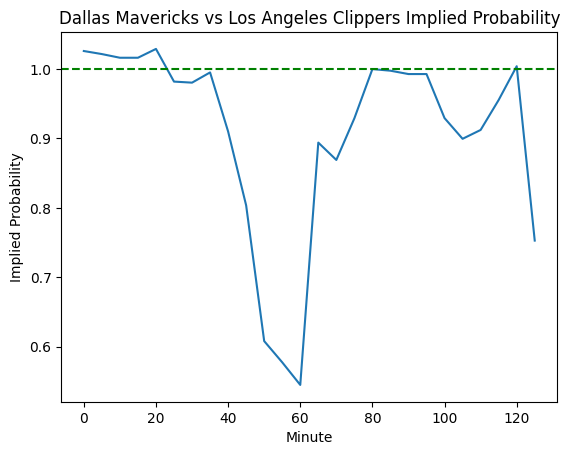

In [351]:
plt.title('Dallas Mavericks vs Los Angeles Clippers Implied Probability')
plt.xlabel('Minute')
plt.ylabel('Implied Probability')
plt.plot(best_odds['implied_prob'])
plt.axhline(y=1, color='green', linestyle='--')



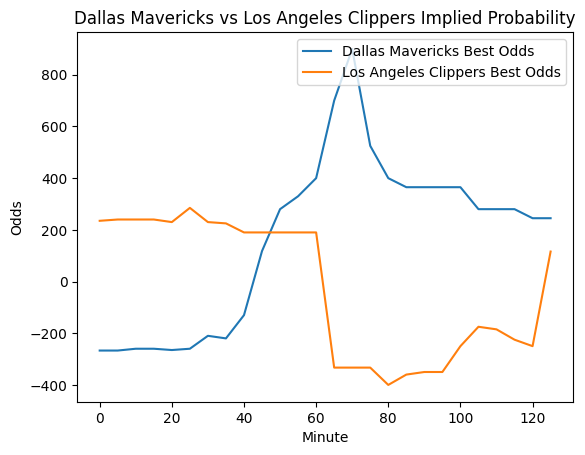

In [352]:
plt.title('Dallas Mavericks vs Los Angeles Clippers Implied Probability')
plt.xlabel('Minute')
plt.ylabel('Odds')
plt.plot(best_odds['Odds1'], label='Dallas Mavericks Best Odds')
plt.plot(best_odds['Odds2'], label='Los Angeles Clippers Best Odds')
plt.legend()


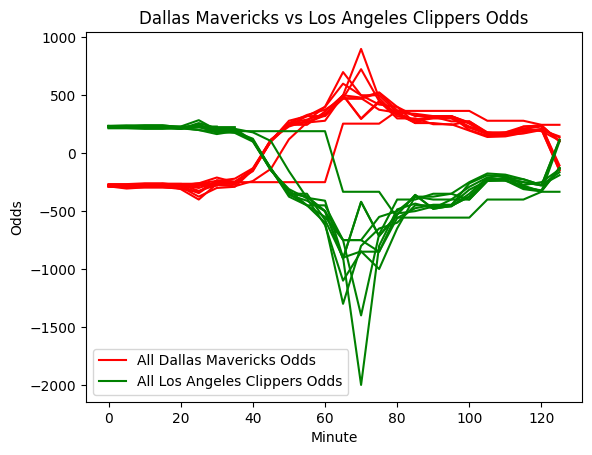

In [377]:

plt.plot(nba_game_odds['BetMGM']['Odds1'], color = 'red')
plt.plot(nba_game_odds['BetOnline.ag']['Odds1'], color = 'red')
plt.plot(nba_game_odds['BetRivers']['Odds1'], color = 'red')
plt.plot(nba_game_odds['Bovada']['Odds1'], color = 'red')
plt.plot(nba_game_odds['Caesars']['Odds1'], color = 'red')
plt.plot(nba_game_odds['DraftKings']['Odds1'], color = 'red')
plt.plot(nba_game_odds['FanDuel']['Odds1'], color = 'red')
plt.plot(nba_game_odds['LowVig.ag']['Odds1'], color = 'red')
plt.plot(nba_game_odds['MyBookie.ag']['Odds1'], color = 'red')
plt.plot(nba_game_odds['PointsBet (US)']['Odds1'], color = 'red')
plt.plot(nba_game_odds['SuperBook']['Odds1'], color = 'red')
plt.plot(nba_game_odds['Unibet']['Odds1'], color = 'red')
plt.plot(nba_game_odds['WynnBET']['Odds1'], color = 'red')
plt.plot(nba_game_odds['BetUS']['Odds1'], color = 'red', label = 'All Dallas Mavericks Odds')

plt.plot(nba_game_odds['BetMGM']['Odds2'], color = 'green')
plt.plot(nba_game_odds['BetOnline.ag']['Odds2'], color = 'green')
plt.plot(nba_game_odds['BetRivers']['Odds2'], color = 'green')
plt.plot(nba_game_odds['Bovada']['Odds2'], color = 'green')
plt.plot(nba_game_odds['Caesars']['Odds2'], color = 'green')
plt.plot(nba_game_odds['DraftKings']['Odds2'], color = 'green')
plt.plot(nba_game_odds['FanDuel']['Odds2'], color = 'green')
plt.plot(nba_game_odds['LowVig.ag']['Odds2'], color = 'green')
plt.plot(nba_game_odds['MyBookie.ag']['Odds2'], color = 'green')
plt.plot(nba_game_odds['PointsBet (US)']['Odds2'], color = 'green')
plt.plot(nba_game_odds['SuperBook']['Odds2'], color = 'green')
plt.plot(nba_game_odds['Unibet']['Odds2'], color = 'green')
plt.plot(nba_game_odds['WynnBET']['Odds2'], color = 'green')
plt.plot(nba_game_odds['BetUS']['Odds2'], color = 'green', label = 'All Los Angeles Clippers Odds')



plt.title('Dallas Mavericks vs Los Angeles Clippers Odds')
plt.xlabel('Minute')
plt.ylabel('Odds')
plt.legend()